In [3]:
# Configuration
gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"

# --- Standard Libraries ---
import sys
import os
import json
import time
import copy
import cmath
import pickle
import logging
import argparse

# Path configuration (only run once)
sys.path.append(gems_tco_path)

# --- Third-Party Libraries ---
from pathlib import Path
from typing import Optional, List, Tuple, Dict, Any, Callable
from json import JSONEncoder

# Data manipulation and analysis
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
import typer

# Torch and Numerical Libraries
import torch
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
from torch.nn import Parameter
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import matplotlib.pyplot as plt 

# --- Custom (GEMS_TCO) Imports ---
import GEMS_TCO
from GEMS_TCO import kernels_reparam_space_time_gpu
from GEMS_TCO import data_preprocess, data_preprocess as dmbh
from GEMS_TCO import orderings as _orderings 

from GEMS_TCO import alg_optimization, BaseLogger
from GEMS_TCO import configuration as config
from GEMS_TCO.data_loader import load_data2
from GEMS_TCO import debiased_whittle

12/25/25

그전에 데이터 매칭 했을때는 아래 거의 수평선 나왔는데 지금 3포인트 쓰니까 잘 안나오는데


load monthly data

In [4]:
space: List[str] = ['1', '1']
lat_lon_resolution = [int(s) for s in space]
mm_cond_number: int = 8
years = ['2024']
month_range = [7] 

output_path = input_path = Path(config.mac_estimates_day_path)
data_load_instance = load_data2(config.mac_data_load_path)



lat_range_input=[0,5]      
lon_range_input=[123, 133.0] 

lat_range_input=[-3,2]      
lon_range_input=[121, 131] 

df_map, ord_mm, nns_map = data_load_instance.load_maxmin_ordered_data_bymonthyear(
lat_lon_resolution=lat_lon_resolution, 
mm_cond_number=mm_cond_number,
years_=years, 
months_=month_range,

lat_range=lat_range_input,   
lon_range=lon_range_input
)

In [5]:
daily_aggregated_tensors_dw = [] 
daily_hourly_maps_dw = []      

daily_aggregated_tensors_vecc = [] 
daily_hourly_maps_vecc = []   

for day_index in range(31):
    hour_start_index = day_index * 8
    hour_end_index = (day_index + 1) * 8
    #hour_end_index = day_index*8 + 1
    hour_indices = [hour_start_index, hour_end_index]

    day_hourly_map, day_aggregated_tensor = data_load_instance.load_working_data(
    df_map, 
    hour_indices, 
    ord_mm= None,  # or just omit it
    dtype=torch.float64, # or just omit it 
    keep_ori=False  #keep_exact_loc
    )

    daily_aggregated_tensors_dw.append( day_aggregated_tensor )
    daily_hourly_maps_dw.append( day_hourly_map )

    day_hourly_map, day_aggregated_tensor = data_load_instance.load_working_data(
    df_map, 
    hour_indices, 
    ord_mm= ord_mm,  # or just omit it
    dtype=torch.float64, # or just omit it 
    keep_ori=False  #keep_exact_loc
    )

    daily_aggregated_tensors_vecc.append( day_aggregated_tensor )
    daily_hourly_maps_vecc.append( day_hourly_map )
print(daily_aggregated_tensors_vecc[0].shape)
#print(daily_hourly_maps[0])
nn = daily_aggregated_tensors_vecc[0].shape[0]

torch.Size([145008, 4])


In [ ]:
''' 
instance = dmbh.center_matching_hour(df, lat_start, lat_end, lon_start, lon_end)

for year in years:        # years = [2023,2024]
    for month in months:  
        try:
            # load pickle (dense ORI data)
            pickle_path = os.path.join(mac_data_path, f'pickle_{year}')
            input_filename = f"orbit_map{str(year)[2:]}_{month_str}.pkl"
            input_filepath = os.path.join(pickle_path, input_filename)
            with open(input_filepath, 'rb') as pickle_file:
                loaded_map = pickle.load(pickle_file)
            center_points = instance.make_center_points_wo_calibration(step_lat = step_lat, step_lon= step_lon)
            coarse_cen_map = instance.coarse_by_center(loaded_map, center_points)

            # Save pickle (coarse data)
            output_filename = f"coarse_cen_map_without_decrement_latitude{str(year)[2:]}_{month_str}.pkl"
            output_filepath = os.path.join(pickle_path, output_filename)
            with open(output_filepath, 'wb') as pickle_file:
                pickle.dump(coarse_cen_map, pickle_file)
            
            print(f"Successfully processed and saved data for year {str(year)[2:]} month {month_str}.")
        except FileNotFoundError:
            print(f"Warning: File {input_filename} not found. Skipping.")
        except Exception as e:
            print(f"Error processing file {input_filename}: {e}")
'''

In [ ]:
'''
year = 2024
month_str = "07"

pickle_path = os.path.join(config.mac_data_path, f'pickle_{year}')
output_filename = f"coarse_cen_map_without_decrement_latitude{str(year)[2:]}_{month_str}.pkl"
output_filepath = os.path.join(pickle_path, output_filename)

with open(output_filepath, 'rb') as pickle_file:
    cbmap_ori = pickle.load(pickle_file)


load_data_instance = GEMS_TCO.load_data('')

df_day_list = []
df_day_map_list = []
for i in range(31):
    cur_map, cur_df =load_data_instance.load_working_data_byday_wo_mm(cbmap_ori,[i*8, (i+1)*8])
    df_day_list.append( cur_df )
    df_day_map_list.append( cur_map )
. '''

# background 

why we average a few days for periodograms not variograms

2. The Periodogram Does Not Average (Raw)

The raw periodogram is statistically "Inconsistent."

How it works: When you calculate the FFT for a specific frequency ω, the value depends essentially on just two numbers (the sine and cosine coefficients for that wave), regardless of how much data you have.

The Effect: Even if you increase your data from 100 days to 1,000,000 days, the periodogram point at frequency ω does not become more precise. It just fluctuates wildly around the true value. The "error bar" for each point never shrinks.

Result: The plot looks jagged and noisy because each pixel is an unstable estimate based on a single realization of the process.

3. What about "Aliasing"?

You mentioned aliasing, but that is slightly different:

Aliasing creates Bias (Wrong Peaks). It happens when high-frequency patterns are misidentified as low-frequency ones because the data isn't sampled fast enough. It makes the plot "wrong," but not necessarily "noisy."

# Apply laplacian filter

In [6]:
import torch
import numpy as np
import torch.nn.functional as F

def subset_tensor(df_tensor: torch.Tensor) -> torch.Tensor:
    """
    Subsets a tensor to a specific lat/lon range.
    Columns are assumed to be [lat, lon, ozone, time].
    """
    lat_mask = (df_tensor[:, 0] >= 0) & (df_tensor[:, 0] <= 2.9)
    lon_mask = (df_tensor[:, 1] >= 123.5) & (df_tensor[:, 1] <= 131.7)
    
    # We apply the mask to the full tensor
    df_sub = df_tensor[lat_mask & lon_mask].clone()
    return df_sub

def apply_laplacian_2d_valid_tensor(df_tensor: torch.Tensor) -> torch.Tensor:
    """
    Applies a 2D discrete Laplacian filter using 'mode=valid' on a PyTorch tensor.
    The input tensor columns are assumed to be [lat, lon, ozone, time].
    """
    # Extract unique coordinates and data
    unique_lats = torch.unique(df_tensor[:, 0])
    unique_lons = torch.unique(df_tensor[:, 1])
    
    lat_count = unique_lats.size(0)
    lon_count = unique_lons.size(0)
    
    if df_tensor.size(0) != lat_count * lon_count:
        raise ValueError("Tensor size does not match the grid dimensions (lat * lon).")

    ozone_data = df_tensor[:, 2].reshape(lat_count, lon_count)

    # Define the 3x3 discrete Laplacian kernel as a PyTorch tensor
    laplacian_kernel = torch.tensor([[0, 1, 0],
                                     [1, -4, 1],
                                     [0, 1, 0]], dtype=torch.float64).unsqueeze(0).unsqueeze(0)

    # Reshape ozone data for conv2d: (batch_size, channels, height, width)
    ozone_data_reshaped = ozone_data.unsqueeze(0).unsqueeze(0)

    # Apply convolution
    laplacian_grid_cropped = F.conv2d(ozone_data_reshaped, laplacian_kernel, padding='valid')
    laplacian_values = laplacian_grid_cropped.squeeze().flatten()

    # Determine the new, cropped coordinates
    cropped_lats = unique_lats[1:-1]
    cropped_lons = unique_lons[1:-1]
    
    if len(cropped_lats) == 0 or len(cropped_lons) == 0:
        return torch.empty(0, 4)

    # Create a new meshgrid for the cropped coordinates
    new_lon_grid, new_lat_grid = torch.meshgrid(cropped_lons, cropped_lats, indexing='xy')
    
    # Preserve time from the original tensor
    time_value = df_tensor[0, 3].repeat(laplacian_values.size(0))

    # Create the new tensor
    new_tensor = torch.stack([new_lat_grid.flatten(), new_lon_grid.flatten(), laplacian_values, time_value], dim=1)
    
    return new_tensor

processed_tensor_map = []
processed_df = []

for day_map in daily_hourly_maps_dw:
    
    tensors_to_aggregate = []
    
    for key, tensor in day_map.items():
        # Step 1: Subset the tensor.
        subsetted = subset_tensor(tensor)
        
        if subsetted.size(0) > 0:
            laplacian_applied = apply_laplacian_2d_valid_tensor(subsetted)
            if laplacian_applied.size(0) > 0:
                tensors_to_aggregate.append(laplacian_applied)

    # Step 3: Concatenate all the processed tensors from the 8-hour period.
    if tensors_to_aggregate:
        aggregated_day_tensor = torch.cat(tensors_to_aggregate, dim=0)
        processed_df.append(aggregated_day_tensor)
        
    # The 'processed_tensors' list remains the same, storing the dictionary for each day.
    processed_tensor_map.append(day_map)

# Now, processed_df2 will contain a single aggregated tensor for each day (8-hour period).
# You can inspect the results:
print("Number of aggregated day tensors:", len(processed_df))
if processed_df:
    print("Shape of the first aggregated tensor:", processed_df[0].shape)
    print("First aggregated tensor head:")
    print(processed_df[0][:5])


Number of aggregated day tensors: 31
Shape of the first aggregated tensor: torch.Size([41536, 4])
First aggregated tensor head:
tensor([[ 6.4000e-02,  1.2357e+02, -4.4902e+00,  2.1000e+01],
        [ 6.4000e-02,  1.2363e+02,  7.1846e+00,  2.1000e+01],
        [ 6.4000e-02,  1.2369e+02, -4.4558e+00,  2.1000e+01],
        [ 6.4000e-02,  1.2376e+02, -5.9061e+00,  2.1000e+01],
        [ 6.4000e-02,  1.2382e+02,  3.2019e+00,  2.1000e+01]],
       dtype=torch.float64)


# periodogram (after laplacian filter)

In [7]:
from scipy.fft import fftn, fftshift, fftfreq
from matplotlib.colors import LinearSegmentedColormap

def plot_2d_periodogram_contour(data_2d: np.ndarray):
    """
    Computes the 2D Periodogram (Power Spectral Density) of the input data
    and plots it using contour lines in the frequency domain.

    The plot axes represent the normalized spatial frequencies (wavenumbers),
    with the DC component (zero frequency) centered at (0, 0).

    Args:
        data_2d (np.ndarray): A 2D array of ozone values (assumed to be 64x128).
    """
    M, N = data_2d.shape
    N_TOTAL = M * N
    
    if M != 64 or N != 128:
        print(f"Warning: Expected input shape (64, 128), received {data_2d.shape}. Plotting may be incorrect.")
        # Attempt to proceed only if the total size is correct, otherwise raise
        if N_TOTAL != 8192:
             raise ValueError(f"Input array must contain 8192 elements. Received {N_TOTAL}.")


    # --- 1. Compute 2D FFT and PSD ---
    
    # Compute the 2D Discrete Fourier Transform (DFT)
    fft_coeff = fftn(data_2d)
    
    # Calculate the Power Spectral Density (Periodogram): |FFT|^2 / N
    psd_2d = np.abs(fft_coeff)**2 / N_TOTAL

    # Shift the zero frequency (DC component) to the center of the array
    psd_shifted = fftshift(psd_2d)

    # --- 2. Generate Frequency Axes ---
    
    # fftfreq generates normalized frequencies, ranging from -0.5 to 0.5 cycles/sample
    # We use fftshift to put the zero frequency in the center, matching the PSD shift.
    
    # Frequencies for the Latitude dimension (M=64)
    freq_lat = fftshift(fftfreq(M))
    
    # Frequencies for the Longitude dimension (N=128)
    freq_lon = fftshift(fftfreq(N))

    # Create 2D meshgrid for plotting (Lon Freq, Lat Freq)
    # Note: meshgrid orders X (columns/Lon) first, then Y (rows/Lat)
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon, freq_lat)

    # --- 3. Plotting (Contour) ---

    # Define custom blue colors
    blue_colors = [
        (222/255, 235/255, 247/255), # Lightest blue/white -> Low Power
        (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255),
        (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255),
        (33/255, 113/255, 181/255),
        (8/255, 69/255, 148/255)    # Darkest blue -> High Power (Strong Spectrum)
    ]
    # Create the custom colormap using the LinearSegmentedColormap class
    blue_cmap = LinearSegmentedColormap.from_list("custom_blue", blue_colors)
    
    plt.figure(figsize=(10, 8))
    
    # Use log scale for the contour levels since PSD usually spans many orders of magnitude
    log_psd = np.log10(psd_shifted + np.finfo(float).eps) # Add epsilon to avoid log(0)
    
    # Create 15 logarithmically spaced contour levels
    levels = np.linspace(log_psd.min(), log_psd.max(), 15)
    
    # Use pcolormesh for continuous color mapping of the PSD (using the custom blue map)
    plt.pcolormesh(freq_grid_lon, freq_grid_lat, log_psd, shading='auto', cmap=blue_cmap)
    
    # Overlay contour lines for clarity
    # Note: The white contour lines were removed to enhance color intuition
    
    plt.colorbar(label='Log₁₀(Power Spectral Density)')
    
    # Set labels based on the standard convention (Long Freq on X, Lat Freq on Y)
    plt.xlabel('Longitude Frequency (w₂)')
    plt.ylabel('Latitude Frequency (w₁)')
    plt.title(f'2D Spatial Periodogram Contour (Grid: {M}x{N})')
    
    # Ensure axes are square or equal if desired (optional)
    # plt.gca().set_aspect('equal')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# --- Example Usage (Using Actual 64x128 Ozone Data) ---

M, N = 64, 128
# Assuming processed_df is defined and available globally.

# NOTE: The previous error indicates that d1h1 contains 4 columns, leading to a size 32768.
# We must ensure only the ozone column is reshaped.
try:
    day = 2
    # 1. Select the unique time steps from the data
    unique_times = processed_df[day-1][:, 3].unique()
    # 2. Filter the data to get the first spatial slice (first hour data)
    d1h1_slice = processed_df[day-1][processed_df[day-1][:, 3] == unique_times[0]]

    # CRUCIAL: Select only the ozone column (index 2) and reshape into the M x N grid.
    ozone_signal_2d = d1h1_slice[:, 2].numpy().reshape(M, N)

    # Run the function
    plot_2d_periodogram_contour(ozone_signal_2d)

except NameError:
    print("\nError: The required 'processed_df' tensor is not defined.")
    print("Cannot run the plotting example without input data.")
except IndexError:
    print("\nError: Data filtering failed. Check if processed_df[0] has time index in column 3.")

ValueError: cannot reshape array of size 5192 into shape (64,128)

averaged version

Detected list of 31 tensors. Stacking...
Processing 248 time steps for Averaged Periodogram...


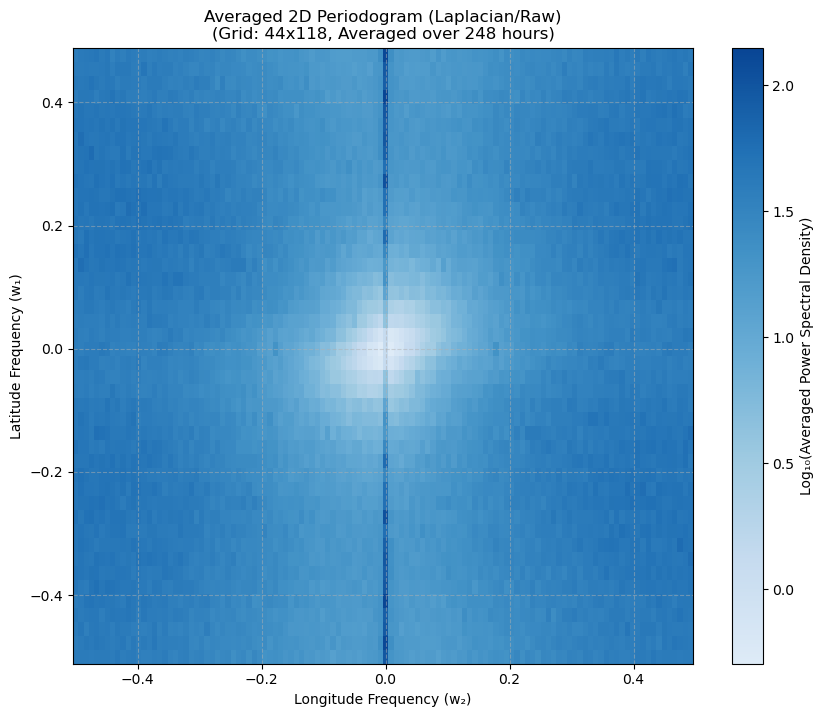

In [8]:
import numpy as np
import torch
from scipy.fft import fftn, fftshift, fftfreq
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def plot_averaged_2d_periodogram_contour(input_data):
    """
    Computes the Averaged 2D Periodogram (PSD) across all time steps in the input.
    
    This function:
    1. Iterates through every hour in the dataset.
    2. Reshapes the 1D data into 2D grids (Dynamically detects M x N).
    3. Computes the 2D FFT and PSD for each snapshot.
    4. Averages the PSDs to reduce noise and visualize the dominant structure.
    
    Args:
        input_data: List of Tensors (e.g. processed_df) or a single stacked Tensor.
                    Expects columns: [Lat, Lon, Ozone, Time]
    """
    
    # --- 1. Data Loading & Preprocessing ---
    # Handle List of Tensors (common in your workflow) or single Tensor/Array
    if isinstance(input_data, list):
        if len(input_data) > 0 and torch.is_tensor(input_data[0]):
            print(f"Detected list of {len(input_data)} tensors. Stacking...")
            combined_tensor = torch.cat(input_data, dim=0)
            data_np = combined_tensor.detach().cpu().numpy()
        else:
            data_np = np.array(input_data)
    elif torch.is_tensor(input_data):
        data_np = input_data.detach().cpu().numpy()
    else:
        data_np = input_data

    # Get all unique time steps
    unique_times = np.unique(data_np[:, 3])
    
    if len(unique_times) == 0:
        print("Error: Input data contains no time information.")
        return

    print(f"Processing {len(unique_times)} time steps for Averaged Periodogram...")

    psd_list = []
    base_shape = None # To ensure all grids match

    # --- 2. Loop Through All Hours ---
    for t_idx, time_val in enumerate(unique_times):
        
        # Slice data for this specific time
        slice_data = data_np[data_np[:, 3] == time_val]
        
        if slice_data.shape[0] == 0:
            continue

        # --- Dynamic Grid Detection ---
        unique_lat = np.sort(np.unique(slice_data[:, 0]))
        unique_lon = np.sort(np.unique(slice_data[:, 1]))
        
        M = len(unique_lat)
        N = len(unique_lon)
        N_TOTAL = M * N
        
        # Skip incomplete or tiny grids
        if M < 2 or N < 2: 
            continue
            
        # Ensure consistency in grid size across days
        if base_shape is None:
            base_shape = (M, N)
        elif (M, N) != base_shape:
            # Skip if this specific hour has a different grid shape (e.g. missing data)
            continue

        # --- Regrid to 2D ---
        # Map values to grid indices
        lat_to_idx = {lat: i for i, lat in enumerate(unique_lat)}
        lon_to_idx = {lon: j for j, lon in enumerate(unique_lon)}
        
        grid_2d = np.full((M, N), np.nan)
        
        # Fill grid (Column 2 is Ozone/Value)
        for row in slice_data:
            r_lat, r_lon, r_val = row[0], row[1], row[2]
            i = lat_to_idx[r_lat]
            j = lon_to_idx[r_lon]
            grid_2d[i, j] = r_val
            
        # Handle NaNs (simple mean fill to allow FFT)
        if np.any(np.isnan(grid_2d)):
            grid_2d[np.isnan(grid_2d)] = np.nanmean(grid_2d)

        # --- 3. Compute FFT & PSD ---
        # No extra differencing here (per your request for "2nd" version)
        
        fft_coeff = fftn(grid_2d)
        
        # PSD = |FFT|^2 / N
        psd_2d = np.abs(fft_coeff)**2 / N_TOTAL
        psd_shifted = fftshift(psd_2d)
        
        psd_list.append(psd_shifted)

    # --- 4. Average and Plot ---
    if not psd_list:
        print("No valid grids processed.")
        return

    # Average the collected PSDs
    avg_psd = np.mean(np.array(psd_list), axis=0)
    
    # Generate Frequency Axes based on the detected shape (M, N)
    freq_lat = fftshift(fftfreq(base_shape[0]))
    freq_lon = fftshift(fftfreq(base_shape[1]))
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon, freq_lat)

    # Define Custom Blue Colormap
    blue_colors = [
        (222/255, 235/255, 247/255), 
        (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255),
        (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255),
        (33/255, 113/255, 181/255),
        (8/255, 69/255, 148/255)    
    ]
    blue_cmap = LinearSegmentedColormap.from_list("custom_blue", blue_colors)
    
    plt.figure(figsize=(10, 8))
    
    # Log scale for visibility
    log_psd = np.log10(avg_psd + np.finfo(float).eps) 
    
    plt.pcolormesh(freq_grid_lon, freq_grid_lat, log_psd, shading='auto', cmap=blue_cmap)
    plt.colorbar(label='Log₁₀(Averaged Power Spectral Density)')
    
    plt.xlabel('Longitude Frequency (w₂)')
    plt.ylabel('Latitude Frequency (w₁)')
    
    plt.title(f'Averaged 2D Periodogram (Laplacian/Raw)\n(Grid: {base_shape[0]}x{base_shape[1]}, Averaged over {len(psd_list)} hours)')
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# --- Example Usage ---
try:
    # Use this function on your Laplacian filtered data list (e.g. processed_df)
    plot_averaged_2d_periodogram_contour(processed_df)
except NameError:
    print("Variable 'processed_df' not found. Please load your data first.")
except Exception as e:
    print(f"An error occurred: {e}")

Standard spectral analysis generally requires the same stationarity conditions as your time domain modeling. If you needed to difference your data for your model (e.g., to remove a unit root or trend), you should almost certainly use that same differenced data for your cross-periodogram.

Here is why your intuition ("I don't need to") might be risky, and why using raw data usually leads to misleading results.

1. The Problem of "Spectral Leakage"



# cross periodogram (2d laplacian filtered data)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, fftshift, fftfreq
from matplotlib.colors import LinearSegmentedColormap

# This function is unchanged.
def calculate_cross_spectrum(data1_2d: np.ndarray, data2_2d: np.ndarray):
    """
    Helper function to compute the 2D cross-spectrum for a single pair of datasets.
    Returns the complex-valued, shifted cross-spectrum.
    """
    if data1_2d.shape != data2_2d.shape:
        raise ValueError("Input data arrays must have the same dimensions.")
    
    M, N = data1_2d.shape
    N_TOTAL = M * N

    # Demean, FFT, and compute the cross-spectrum
    # Note: Demeaning is still good practice even on filtered data.
    d1_demeaned = data1_2d - np.mean(data1_2d)
    d2_demeaned = data2_2d - np.mean(data2_2d)
    fft1 = fftn(d1_demeaned)
    fft2 = fftn(d2_demeaned)
    # The cross-spectrum convention used here is F1 * conj(F2)
    cross_spectrum = (fft1 * np.conj(fft2)) / N_TOTAL
    
    return fftshift(cross_spectrum)

# This function is also unchanged.
def plot_averaged_cross_periodogram(avg_cross_spec: np.ndarray, M: int, N: int, num_days: int):
    """
    Plots the magnitude and phase of a pre-averaged 2D cross-periodogram.
    """
    # --- 1. Separate Averaged Magnitude and Phase ---
    magnitude = np.abs(avg_cross_spec)
    phase = np.angle(avg_cross_spec)

    # --- 2. Generate Frequency Axes ---
    freq_lat = fftshift(fftfreq(M))
    freq_lon = fftshift(fftfreq(N))
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon, freq_lat)

    # --- 3. Plotting (Two Subplots) ---
    blue_cmap = LinearSegmentedColormap.from_list("custom_blue", [
        (222/255, 235/255, 247/255), (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255), (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255), (33/255, 113/255, 181/255),
        (8/255, 69/255, 148/255)
    ])

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    title = f'Averaged 2D Cross-Periodogram on Laplacian-Filtered Data (Grid: {M}x{N}, Averaged over {num_days} days)'
    fig.suptitle(title, fontsize=16)

    # -- Plot 1: Magnitude --
    ax = axes[0]
    log_magnitude = np.log10(magnitude + np.finfo(float).eps)
    im1 = ax.pcolormesh(freq_grid_lon, freq_grid_lat, log_magnitude, cmap=blue_cmap, shading='auto')
    fig.colorbar(im1, ax=ax, label='Log₁₀(Averaged Cross-Spectrum Magnitude)')
    ax.set_title('Magnitude (Strength of Covariance)')
    ax.set_xlabel('Longitude Frequency (w₂)')
    ax.set_ylabel('Latitude Frequency (w₁)')
    ax.grid(True, linestyle='--', alpha=0.5)

    # -- Plot 2: Phase --
    ax = axes[1]
    # 'twilight_shifted' is an excellent colormap for phase data as it is cyclic
    im2 = ax.pcolormesh(freq_grid_lon, freq_grid_lat, phase, cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi, shading='auto')
    fig.colorbar(im2, ax=ax, label='Phase Angle (radians)')
    ax.set_title('Phase (Spatial Lag)')
    ax.set_xlabel('Longitude Frequency (w₂)')
    ax.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## --- Main Script Logic (Adapted for processed_df) ---
# This part loops through the days, calculates, and averages the results.

# Define grid dimensions and processing parameters
M, N = 64, 128
# Assuming processed_df is a list where each element is a tensor for a day's data
# Example: processed_df[0] is day 1, processed_df[1] is day 2, etc.
days_to_average = np.arange(0, 4) # Use the first nine days (Day 1 to Day 9)
keyhour = 3 # This will correspond to the 4th hour (index 3)
cross_spectra_list = []

print(f"Averaging cross-periodogram for hour {keyhour} and {keyhour+1} across {len(days_to_average)} days on Laplacian-filtered data...")

# Loop through the specified day numbers
for day_num in days_to_average:
    day_idx = day_num - 1 # Convert to 0-based index for the list
    try:
        # Get all data for the current day
        daily_data = processed_df[day_idx]
        
        # Get the unique, sorted time steps for this day
        unique_times = np.unique(daily_data[:, 3].numpy())
        
        # --- Load data for the first hour ---
        time1 = unique_times[keyhour]
        slice1 = daily_data[daily_data[:, 3] == time1]
        ozone_signal_1 = slice1[:, 2].numpy().reshape(M, N)

        # --- Load data for the consecutive hour ---
        time2 = unique_times[keyhour + 1]
        slice2 = daily_data[daily_data[:, 3] == time2]
        ozone_signal_2 = slice2[:, 2].numpy().reshape(M, N)
        
        # Calculate the cross-spectrum for this day and add it to our list
        daily_cross_spec = calculate_cross_spectrum(ozone_signal_1, ozone_signal_2)
        cross_spectra_list.append(daily_cross_spec)
        print(f"  - Successfully processed Day {day_num}.")

    except IndexError:
        print(f"  - Could not process Day {day_num}. Reason: Not enough hours available in data for hour index {keyhour+1}.")
    except Exception as e:
        print(f"  - Could not process Day {day_num}. Reason: {e}")

# --- Averaging and Plotting ---
if cross_spectra_list:
    # Stack all the daily spectra into a 3D array and average along the 'day' axis
    avg_cross_spec = np.mean(np.array(cross_spectra_list), axis=0)
    
    # Plot the final averaged result
    plot_averaged_cross_periodogram(avg_cross_spec, M, N, len(cross_spectra_list))
else:
    print("\nNo data was successfully processed. Cannot generate plot.")

Averaging cross-periodogram for hour 3 and 4 across 4 days on Laplacian-filtered data...
  - Could not process Day 0. Reason: cannot reshape array of size 5192 into shape (64,128)
  - Could not process Day 1. Reason: cannot reshape array of size 5192 into shape (64,128)
  - Could not process Day 2. Reason: cannot reshape array of size 5192 into shape (64,128)
  - Could not process Day 3. Reason: cannot reshape array of size 5192 into shape (64,128)

No data was successfully processed. Cannot generate plot.


# first differenced data

You should likely use the First Differenced (111.png) version for your paper if you are discussing wind direction.

Why? Original data is often dominated by a "red noise" trend (high power at low frequencies) which creates a generic "blob" at the center. Differencing whitens the data, making the specific directional stretching (the anisotropy caused by wind) easier to see in the contours.

In [10]:
a = [11.0474, 0.0623, 0.2445, 1.0972, 0.0101, -0.1671, 1.1825]
day = 0 # 0 index
lat_range= [0,5]
lon_range= [123.0, 133.0]


subsetted_aggregated_day_diffonce = []
days_to_average = np.arange(1, 5) 
for day_num in days_to_average:
    day_idx = day_num -1
    db = debiased_whittle.debiased_whittle_preprocess(daily_aggregated_tensors_dw, daily_hourly_maps_dw, day_idx=day, params_list=a, lat_range=lat_range, lon_range=lon_range)

    subsetted_aggregated_day = db.generate_spatially_filtered_days(0,5,123,133)
    
    N2= subsetted_aggregated_day.shape[0]
    
    subsetted_aggregated_day_diffonce.append(subsetted_aggregated_day)
print(subsetted_aggregated_day.shape)
print(N2)
print(subsetted_aggregated_day_diffonce[0])



torch.Size([45360, 4])
45360
tensor([[ 2.0000e-02,  1.2306e+02,  7.0969e-01,  2.1000e+01],
        [ 2.0000e-02,  1.2313e+02,  1.6618e+00,  2.1000e+01],
        [ 2.0000e-02,  1.2319e+02,  2.6658e+00,  2.1000e+01],
        ...,
        [ 1.9560e+00,  1.3081e+02,  3.7727e+00,  2.8000e+01],
        [ 1.9560e+00,  1.3087e+02,  3.4274e+00,  2.8000e+01],
        [ 1.9560e+00,  1.3094e+02, -5.9504e-01,  2.8000e+01]],
       dtype=torch.float64)


In [11]:
import numpy as np
import torch
from scipy.fft import fftn, fftshift, fftfreq
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def regrid_and_plot_2d_periodogram(subsetted_aggregated_day: torch.Tensor):
    """
    1. Regrids the 1D list of spatial-temporal observations (subsetted_aggregated_day) 
       into a 2D grid for a single hour.
    2. Applies first differencing to the 2D grid in the latitude direction.
    3. Computes the 2D Periodogram (Power Spectral Density) of the 
       spatially differenced signal.
    4. Plots the result in the frequency domain.

    Args:
        subsetted_aggregated_day (torch.Tensor): A tensor of shape (N2, 4) 
            where columns are [lat, lon, value, hour]. 
    """
    
    # Ensure the input is a NumPy array for processing
    data_np = subsetted_aggregated_day.numpy()
    
    # --- 1. Regrid the 1D Data to a 2D Grid ---
    
    # Select a single hour for the 2D spatial analysis (e.g., the first hour found)
    unique_hours = np.unique(data_np[:, 3])
    if len(unique_hours) == 0:
        raise ValueError("Input data contains no time/hour information.")
        
    hour_to_process = unique_hours[0] 
    
    # Filter for the selected hour
    spatial_slice = data_np[data_np[:, 3] == hour_to_process]
    
    # Get unique lat/lon to determine grid shape (M x N)
    unique_lat = np.sort(np.unique(spatial_slice[:, 0]))
    unique_lon = np.sort(np.unique(spatial_slice[:, 1]))
    
    M = len(unique_lat) # Lat dim (rows)
    N = len(unique_lon) # Lon dim (cols)
    
    if M <= 1 or N <= 1:
         raise ValueError(f"Grid size is too small for 2D FFT: {M}x{N}. Need at least 2x2.")

    # Create a mapping from lat/lon values to their index (row/col)
    lat_to_idx = {lat: i for i, lat in enumerate(unique_lat)}
    lon_to_idx = {lon: j for j, lon in enumerate(unique_lon)}
    
    # Initialize the 2D grid (M rows, N columns) using NaN to spot gaps
    # The 'value' column is index 2
    value_signal_2d = np.full((M, N), np.nan) 
    
    # Populate the 2D grid
    for lat, lon, value, _ in spatial_slice:
        i = lat_to_idx[lat]
        j = lon_to_idx[lon]
        value_signal_2d[i, j] = value
        
    if np.any(np.isnan(value_signal_2d)):
        # Fill NaNs with the mean or zero if necessary for FFT
        # For simplicity, we fill with the mean of non-NaN values
        mean_val = np.nanmean(value_signal_2d)
        value_signal_2d[np.isnan(value_signal_2d)] = mean_val
        print("Warning: Gaps (NaNs) found and filled with the mean for FFT computation.")


    # --- 2. Apply First Differencing in Space (Latitude Direction) ---
    
    # The first difference is calculated: d_i,j = X_i,j - X_{i-1, j}
    # This reduces the latitude dimension by 1.
    data_2d = value_signal_2d[1:, :] - value_signal_2d[:-1, :]
    
    M_diff, N_diff = data_2d.shape
    N_TOTAL = M_diff * N_diff

    print(f"\nProcessing Hour: {hour_to_process}. Original Grid: {M}x{N}. Differenced Grid: {M_diff}x{N_diff}")
    
    # --- 3. Compute 2D FFT and PSD ---
    
    # Compute the 2D Discrete Fourier Transform (DFT) on the differenced signal
    fft_coeff = fftn(data_2d)
    
    # Calculate the Power Spectral Density (Periodogram): |FFT|^2 / N_TOTAL
    psd_2d = np.abs(fft_coeff)**2 / N_TOTAL

    # Shift the zero frequency (DC component) to the center of the array
    psd_shifted = fftshift(psd_2d)

    # --- 4. Generate Frequency Axes ---
    
    # Frequencies for the Latitude dimension (M_diff)
    freq_lat = fftshift(fftfreq(M_diff))
    
    # Frequencies for the Longitude dimension (N_diff)
    freq_lon = fftshift(fftfreq(N_diff))

    # Create 2D meshgrid for plotting (Lon Freq, Lat Freq)
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon, freq_lat)

    # --- 5. Plotting (Contour) ---

    blue_colors = [
        (222/255, 235/255, 247/255), 
        (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255),
        (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255),
        (33/255, 113/255, 181/255),
        (8/255, 69/255, 148/255)    
    ]
    blue_cmap = LinearSegmentedColormap.from_list("custom_blue", blue_colors)
    
    plt.figure(figsize=(10, 8))
    
    # Use log scale for the contour levels
    log_psd = np.log10(psd_shifted + np.finfo(float).eps) 
    
    levels = np.linspace(log_psd.min(), log_psd.max(), 15)
    
    # Use pcolormesh for continuous color mapping
    plt.pcolormesh(freq_grid_lon, freq_grid_lat, log_psd, shading='auto', cmap=blue_cmap)
    
    plt.colorbar(label='Log₁₀(Power Spectral Density)')
    
    plt.xlabel('Longitude Frequency (w₂)')
    plt.ylabel('Latitude Frequency (w₁)')
    plt.title(f'2D Spatial Periodogram (First Differenced, Grid: {M_diff}x{N_diff})')
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    


# --- Execute Function with Your Data ---

# NOTE: This block assumes your actual data tensor is accessible by this name.

try:
    regrid_and_plot_2d_periodogram(subsetted_aggregated_day_diffonce)
except NameError:
    print("\nERROR: The variable 'subsetted_aggregated_day' is not defined.")
    print("Please ensure your data loading steps (debiased_whittle_preprocess, generate_spatially_filtered_days) have been run first.")
except Exception as e:
    print(f"\nAn error occurred during periodogram computation: {e}")


An error occurred during periodogram computation: 'list' object has no attribute 'numpy'


try averaged periodograms for consistency

Detected a list of 4 tensors. Stacking them...
Computing Periodograms for 8 time steps to average...


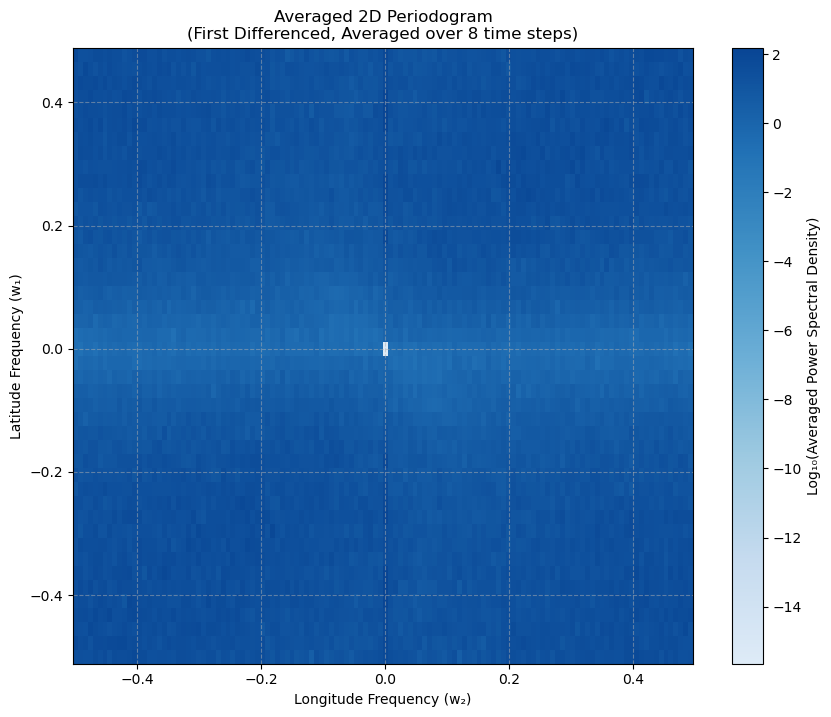

In [12]:
import numpy as np
import torch
from scipy.fft import fftn, fftshift, fftfreq
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def regrid_and_plot_averaged_periodogram(input_data):
    """
    Calculates and plots the 2D Periodogram averaged over all available time steps.
    
    Args:
        input_data: Can be a single Tensor, a List of Tensors, or a NumPy array.
    """
    
    # --- 1. ROBUST DATA LOADING (Fixes the "list indices" error) ---
    if isinstance(input_data, list):
        # Check if it's a list of Tensors (common in your workflow)
        if len(input_data) > 0 and torch.is_tensor(input_data[0]):
            # Stack all days into one big tensor
            print(f"Detected a list of {len(input_data)} tensors. Stacking them...")
            combined_tensor = torch.cat(input_data, dim=0)
            data_np = combined_tensor.detach().cpu().numpy()
        else:
            # Assume it's a list of lists or numpy arrays
            data_np = np.array(input_data)
    elif torch.is_tensor(input_data):
        data_np = input_data.detach().cpu().numpy()
    else:
        data_np = input_data

    # --- 2. Iterate and Compute Periodograms ---
    
    # Get all unique hours/timestamps across the entire dataset
    # (Note: index 3 is time)
    unique_times = np.unique(data_np[:, 3])
    
    if len(unique_times) == 0:
        print("Error: Input data is empty or contains no time information.")
        return

    print(f"Computing Periodograms for {len(unique_times)} time steps to average...")

    psd_list = []
    
    for t_idx, time_val in enumerate(unique_times):
        
        # Slice data for this specific time
        spatial_slice = data_np[data_np[:, 3] == time_val]
        
        # Safety check: skip if slice is empty
        if spatial_slice.shape[0] == 0:
            continue
            
        # --- Dynamic Grid Detection ---
        unique_lat = np.sort(np.unique(spatial_slice[:, 0]))
        unique_lon = np.sort(np.unique(spatial_slice[:, 1]))
        
        M = len(unique_lat)
        N = len(unique_lon)
        
        # Need at least 2x2 grid to calculate difference and FFT
        if M <= 1 or N <= 1:
            continue

        # --- Regrid to 2D ---
        lat_to_idx = {lat: i for i, lat in enumerate(unique_lat)}
        lon_to_idx = {lon: j for j, lon in enumerate(unique_lon)}
        
        value_signal_2d = np.full((M, N), np.nan)
        
        # Fill grid (Vectorized fill is faster, but loop is safer for irregular data)
        # Using loop here for safety with your data format
        for row in spatial_slice:
            lat, lon, val = row[0], row[1], row[2]
            i = lat_to_idx[lat]
            j = lon_to_idx[lon]
            value_signal_2d[i, j] = val
            
        # Handle NaNs
        if np.any(np.isnan(value_signal_2d)):
            mean_val = np.nanmean(value_signal_2d)
            value_signal_2d[np.isnan(value_signal_2d)] = mean_val

        # --- Apply First Differencing (Latitude Direction) ---
        # Matches your logic: X[i, j] - X[i-1, j]
        diff_grid = value_signal_2d[1:, :] - value_signal_2d[:-1, :]
        
        M_diff, N_diff = diff_grid.shape
        N_TOTAL = M_diff * N_diff
        
        # --- Compute FFT & PSD ---
        d_demeaned = diff_grid - np.mean(diff_grid)
        fft_coeff = fftn(d_demeaned)
        
        # Power Spectral Density = |FFT|^2 / N
        psd_2d = np.abs(fft_coeff)**2 / N_TOTAL
        psd_shifted = fftshift(psd_2d)
        
        psd_list.append(psd_shifted)

    # --- 3. Averaging ---
    if not psd_list:
        print("No valid data found to plot (grids might be too small).")
        return

    # Check if all PSDs have the same shape before averaging
    # (If grid size changes between days, we cannot simply mean them)
    base_shape = psd_list[0].shape
    valid_psds = [p for p in psd_list if p.shape == base_shape]
    
    if len(valid_psds) < len(psd_list):
        print(f"Warning: Dropped {len(psd_list) - len(valid_psds)} slices due to grid size mismatch.")

    if not valid_psds:
        print("No matching grid shapes found.")
        return

    avg_psd = np.mean(np.array(valid_psds), axis=0)
    
    # --- 4. Plotting ---
    freq_lat = fftshift(fftfreq(base_shape[0]))
    freq_lon = fftshift(fftfreq(base_shape[1]))
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon, freq_lat)

    blue_colors = [
        (222/255, 235/255, 247/255), 
        (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255),
        (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255),
        (33/255, 113/255, 181/255),
        (8/255, 69/255, 148/255)    
    ]
    blue_cmap = LinearSegmentedColormap.from_list("custom_blue", blue_colors)
    
    plt.figure(figsize=(10, 8))
    
    # Log scale for visibility
    log_psd = np.log10(avg_psd + np.finfo(float).eps) 
    
    plt.pcolormesh(freq_grid_lon, freq_grid_lat, log_psd, shading='auto', cmap=blue_cmap)
    plt.colorbar(label='Log₁₀(Averaged Power Spectral Density)')
    
    plt.xlabel('Longitude Frequency (w₂)')
    plt.ylabel('Latitude Frequency (w₁)')
    
    title_str = f'Averaged 2D Periodogram\n(First Differenced, Averaged over {len(valid_psds)} time steps)'
    plt.title(title_str)
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# --- Execute ---
# Try running this again. It will now handle lists automatically.
try:
    regrid_and_plot_averaged_periodogram(subsetted_aggregated_day_diffonce)
except NameError:
    print("Variable 'subsetted_aggregated_day_diffonce' not found.")
except Exception as e:
    print(f"Error: {e}")

Detected a list of 4 tensors. Stacking them...
Computing Periodograms for 8 time steps to average...


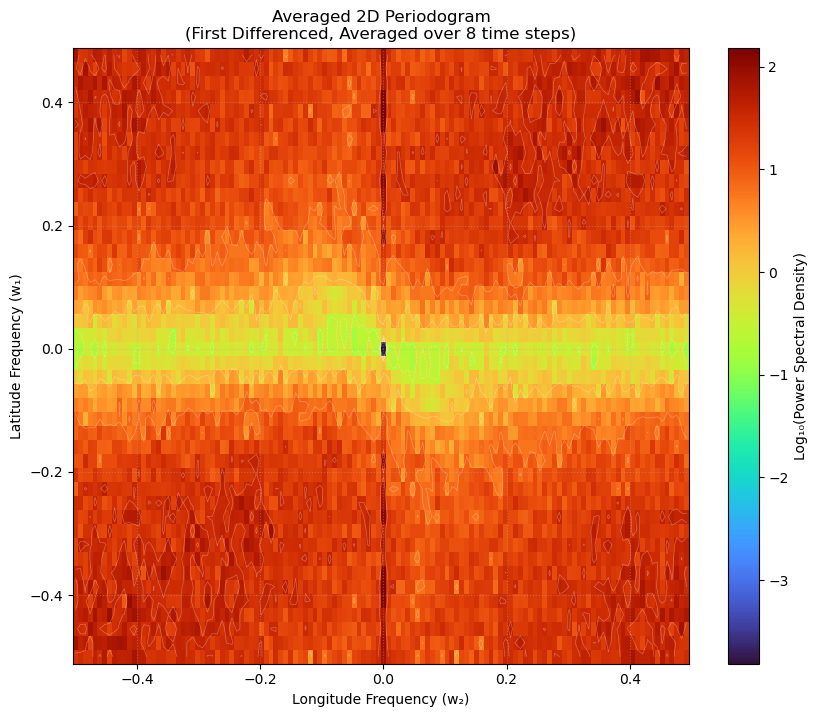

In [13]:
import numpy as np
import torch
from scipy.fft import fftn, fftshift, fftfreq
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def regrid_and_plot_averaged_periodogram(input_data):
    """
    Calculates and plots the 2D Periodogram averaged over all available time steps.
    Includes contrast enhancement (scaling clipping) and turbo colormap.
    """
    
    # --- 1. ROBUST DATA LOADING ---
    if isinstance(input_data, list):
        if len(input_data) > 0 and torch.is_tensor(input_data[0]):
            print(f"Detected a list of {len(input_data)} tensors. Stacking them...")
            combined_tensor = torch.cat(input_data, dim=0)
            data_np = combined_tensor.detach().cpu().numpy()
        else:
            data_np = np.array(input_data)
    elif torch.is_tensor(input_data):
        data_np = input_data.detach().cpu().numpy()
    else:
        data_np = input_data

    # --- 2. Iterate and Compute Periodograms ---
    unique_times = np.unique(data_np[:, 3])
    
    if len(unique_times) == 0:
        print("Error: Input data is empty or contains no time information.")
        return

    print(f"Computing Periodograms for {len(unique_times)} time steps to average...")

    psd_list = []
    
    for t_idx, time_val in enumerate(unique_times):
        spatial_slice = data_np[data_np[:, 3] == time_val]
        if spatial_slice.shape[0] == 0: continue
            
        unique_lat = np.sort(np.unique(spatial_slice[:, 0]))
        unique_lon = np.sort(np.unique(spatial_slice[:, 1]))
        M, N = len(unique_lat), len(unique_lon)
        
        if M <= 1 or N <= 1: continue

        lat_to_idx = {lat: i for i, lat in enumerate(unique_lat)}
        lon_to_idx = {lon: j for j, lon in enumerate(unique_lon)}
        
        value_signal_2d = np.full((M, N), np.nan)
        for row in spatial_slice:
            lat, lon, val = row[0], row[1], row[2]
            i = lat_to_idx[lat]
            j = lon_to_idx[lon]
            value_signal_2d[i, j] = val
            
        if np.any(np.isnan(value_signal_2d)):
            mean_val = np.nanmean(value_signal_2d)
            value_signal_2d[np.isnan(value_signal_2d)] = mean_val

        # --- Apply First Differencing (Latitude Direction) ---
        diff_grid = value_signal_2d[1:, :] - value_signal_2d[:-1, :]
        M_diff, N_diff = diff_grid.shape
        N_TOTAL = M_diff * N_diff
        
        d_demeaned = diff_grid - np.mean(diff_grid)
        fft_coeff = fftn(d_demeaned)
        psd_2d = np.abs(fft_coeff)**2 / N_TOTAL
        psd_shifted = fftshift(psd_2d)
        psd_list.append(psd_shifted)

    # --- 3. Averaging ---
    if not psd_list:
        print("No valid data found to plot.")
        return

    base_shape = psd_list[0].shape
    valid_psds = [p for p in psd_list if p.shape == base_shape]
    
    if len(valid_psds) < len(psd_list):
        print(f"Warning: Dropped {len(psd_list) - len(valid_psds)} slices due to grid size mismatch.")

    if not valid_psds:
        print("No matching grid shapes found.")
        return

    avg_psd = np.mean(np.array(valid_psds), axis=0)
    
    # --- 4. Plotting (Improved Contrast & Contours) ---
    freq_lat = fftshift(fftfreq(base_shape[0]))
    freq_lon = fftshift(fftfreq(base_shape[1]))
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon, freq_lat)

    plt.figure(figsize=(10, 8))
    
    # Log scale with epsilon
    log_psd = np.log10(avg_psd + 1e-10) 
    
    # --- SMART SCALING ---
    # Ignore the "hole" at -15 and focus on the top power.
    # We clip the range to show the top 6 orders of magnitude relative to the peak.
    max_val = np.max(log_psd)
    min_val = max_val - 6
    
    # Use 'turbo' or 'jet' for better spectral visibility
    # vmin/vmax ensures the colorbar focuses on the relevant data range
    plt.pcolormesh(
        freq_grid_lon, 
        freq_grid_lat, 
        log_psd, 
        shading='auto', 
        cmap='turbo', 
        vmin=min_val, 
        vmax=max_val
    )
    
    cbar = plt.colorbar()
    cbar.set_label('Log₁₀(Power Spectral Density)')
    
    # Add white contour lines to emphasize directionality
    plt.contour(
        freq_grid_lon, 
        freq_grid_lat, 
        log_psd, 
        levels=np.linspace(min_val, max_val, 10), 
        colors='white', 
        alpha=0.3, 
        linewidths=0.5
    )
    
    plt.xlabel('Longitude Frequency (w₂)')
    plt.ylabel('Latitude Frequency (w₁)')
    
    title_str = f'Averaged 2D Periodogram\n(First Differenced, Averaged over {len(valid_psds)} time steps)'
    plt.title(title_str)
    
    # Ensure aspect ratio is square so circles look like circles
    plt.gca().set_aspect('equal')
    plt.grid(True, linestyle=':', alpha=0.4)
    plt.show()

# --- Execute ---
try:
    regrid_and_plot_averaged_periodogram(subsetted_aggregated_day_diffonce)
except NameError:
    print("Variable 'subsetted_aggregated_day_diffonce' not found.")
except Exception as e:
    print(f"Error: {e}")

Averaging cross-periodogram for hour 3 & 4 across 4 days...
  - Day 1: Processed Grid 44x118 -> Filtered (43, 117)
  - Day 2: Processed Grid 44x118 -> Filtered (43, 117)
  - Day 3: Processed Grid 44x118 -> Filtered (43, 117)
  - Day 4: Processed Grid 44x118 -> Filtered (43, 117)


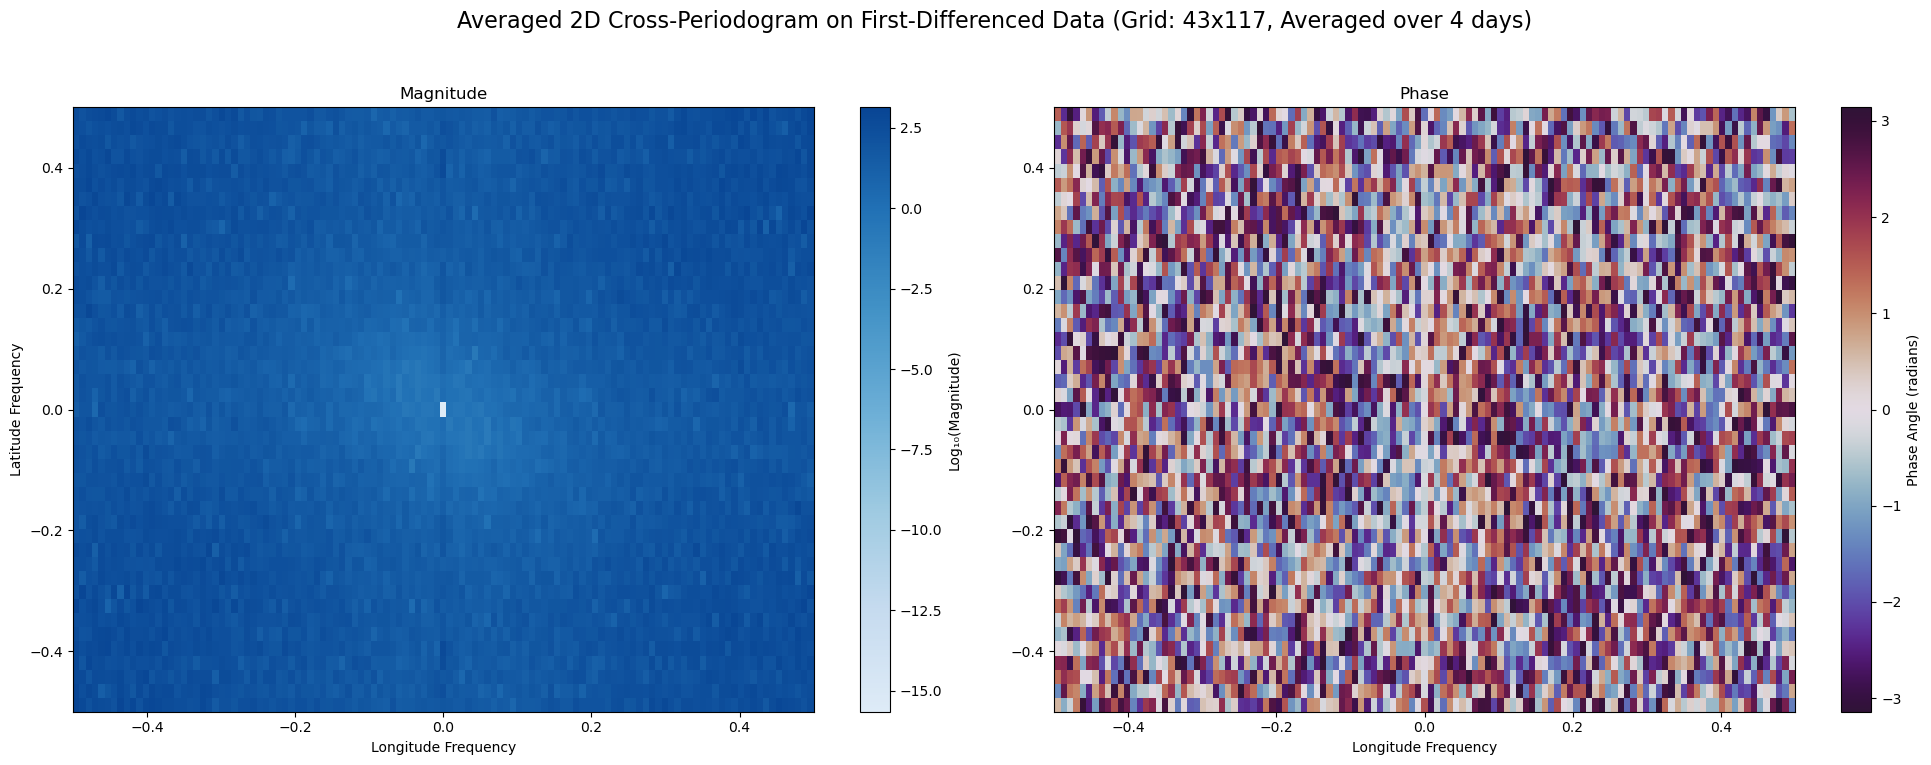

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from scipy.fft import fftn, fftshift, fftfreq
from matplotlib.colors import LinearSegmentedColormap

# --- 1. Helper: First Difference Filter ---
def get_first_differenced_grid(slice_tensor: torch.Tensor, raw_M: int, raw_N: int):
    """
    Applies the specific 2D first-order difference filter.
    """
    if slice_tensor.dtype != torch.float64:
        slice_tensor = slice_tensor.to(torch.float64)

    # Safety Check: Ensure the reshaping is valid
    expected_size = raw_M * raw_N
    actual_size = slice_tensor.shape[0]
    if expected_size != actual_size:
        raise ValueError(f"Grid mismatch: Expected {expected_size} points ({raw_M}x{raw_N}), but got {actual_size}.")

    # Reshape 'ozone' column (index 2) to (1, 1, M, N)
    ozone_data = slice_tensor[:, 2].reshape(1, 1, raw_M, raw_N)
    
    # Define the kernel: [[-2, 1], [1, 0]]
    diff_kernel = torch.tensor([[[[-2., 1.],
                                  [ 1., 0.]]]], dtype=torch.float64).to(slice_tensor.device)
    
    # Apply Convolution (Padding='valid' reduces dims by 1)
    filtered_grid = F.conv2d(ozone_data, diff_kernel, padding='valid')
    
    return filtered_grid.squeeze().detach().cpu().numpy()

# --- 2. Helper: Cross Spectrum ---
def calculate_cross_spectrum(data1_2d: np.ndarray, data2_2d: np.ndarray):
    if data1_2d.shape != data2_2d.shape:
        raise ValueError(f"Shape mismatch in spectrum calculation: {data1_2d.shape} vs {data2_2d.shape}")
    
    M, N = data1_2d.shape
    d1_demeaned = data1_2d - np.mean(data1_2d)
    d2_demeaned = data2_2d - np.mean(data2_2d)
    
    fft1 = fftn(d1_demeaned)
    fft2 = fftn(d2_demeaned)
    
    cross_spectrum = (fft1 * np.conj(fft2)) / (M * N)
    return fftshift(cross_spectrum)

# --- 3. Helper: Plotting ---
def plot_averaged_cross_periodogram(avg_cross_spec: np.ndarray, M: int, N: int, num_days: int):
    magnitude = np.abs(avg_cross_spec)
    phase = np.angle(avg_cross_spec)

    freq_lat = fftshift(fftfreq(M))
    freq_lon = fftshift(fftfreq(N))
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon, freq_lat)

    blue_cmap = LinearSegmentedColormap.from_list("custom_blue", [
        (222/255, 235/255, 247/255), (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255), (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255), (33/255, 113/255, 181/255),
        (8/255, 69/255, 148/255)
    ])

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    title = f'Averaged 2D Cross-Periodogram on First-Differenced Data (Grid: {M}x{N}, Averaged over {num_days} days)'
    fig.suptitle(title, fontsize=16)

    # -- Plot 1: Magnitude --
    ax = axes[0]
    log_magnitude = np.log10(magnitude + np.finfo(float).eps)
    im1 = ax.pcolormesh(freq_grid_lon, freq_grid_lat, log_magnitude, cmap=blue_cmap, shading='auto')
    fig.colorbar(im1, ax=ax, label='Log₁₀(Magnitude)')
    ax.set_title('Magnitude')
    ax.set_xlabel('Longitude Frequency')
    ax.set_ylabel('Latitude Frequency')

    # -- Plot 2: Phase --
    ax = axes[1]
    im2 = ax.pcolormesh(freq_grid_lon, freq_grid_lat, phase, cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi, shading='auto')
    fig.colorbar(im2, ax=ax, label='Phase Angle (radians)')
    ax.set_title('Phase')
    ax.set_xlabel('Longitude Frequency')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## --- Main Script Logic ---

# We do NOT hardcode M_RAW, N_RAW anymore.
days_to_average = np.arange(1, 5) # Process days 1, 2, 3, 4
keyhour = 3 
cross_spectra_list = []

print(f"Averaging cross-periodogram for hour {keyhour} & {keyhour+1} across {len(days_to_average)} days...")

for day_num in days_to_average:
    day_idx = day_num - 1
    try:
        # Load the data tensor
        daily_data = processed_df[day_idx]
        
        # --- DYNAMIC GRID DETECTION ---
        # 1. Identify unique latitudes and longitudes in this specific day's data
        #    This automatically handles your specific subset (e.g., 17854 points)
        unique_lats = torch.unique(daily_data[:, 0])
        unique_lons = torch.unique(daily_data[:, 1])
        unique_times = np.unique(daily_data[:, 3].numpy())
        
        M_curr = len(unique_lats)
        N_curr = len(unique_lons)
        
        # --- Slice 1: Hour t ---
        time1 = unique_times[keyhour]
        slice1 = daily_data[daily_data[:, 3] == time1]
        
        # Apply First Difference (Pass the dynamically detected M and N)
        ozone_signal_1 = get_first_differenced_grid(slice1, M_curr, N_curr)

        # --- Slice 2: Hour t+1 ---
        time2 = unique_times[keyhour + 1]
        slice2 = daily_data[daily_data[:, 3] == time2]
        
        # Apply First Difference
        ozone_signal_2 = get_first_differenced_grid(slice2, M_curr, N_curr)
        
        # Calculate Cross Spectrum
        daily_cross_spec = calculate_cross_spectrum(ozone_signal_1, ozone_signal_2)
        cross_spectra_list.append(daily_cross_spec)
        
        print(f"  - Day {day_num}: Processed Grid {M_curr}x{N_curr} -> Filtered {ozone_signal_1.shape}")

    except IndexError as e:
        print(f"  - Day {day_num} Skipped: Index Error (Check hours available). {e}")
    except ValueError as e:
        print(f"  - Day {day_num} Skipped: Grid Mismatch. {e}")
    except Exception as e:
        print(f"  - Day {day_num} Skipped: {e}")

# --- Averaging and Plotting ---
if cross_spectra_list:
    avg_cross_spec = np.mean(np.array(cross_spectra_list), axis=0)
    # The final shape will be (M-1, N-1) due to the filter
    M_final, N_final = avg_cross_spec.shape
    plot_averaged_cross_periodogram(avg_cross_spec, M_final, N_final, len(cross_spectra_list))
else:
    print("\nNo data was successfully processed. Cannot generate plot.")

# original data

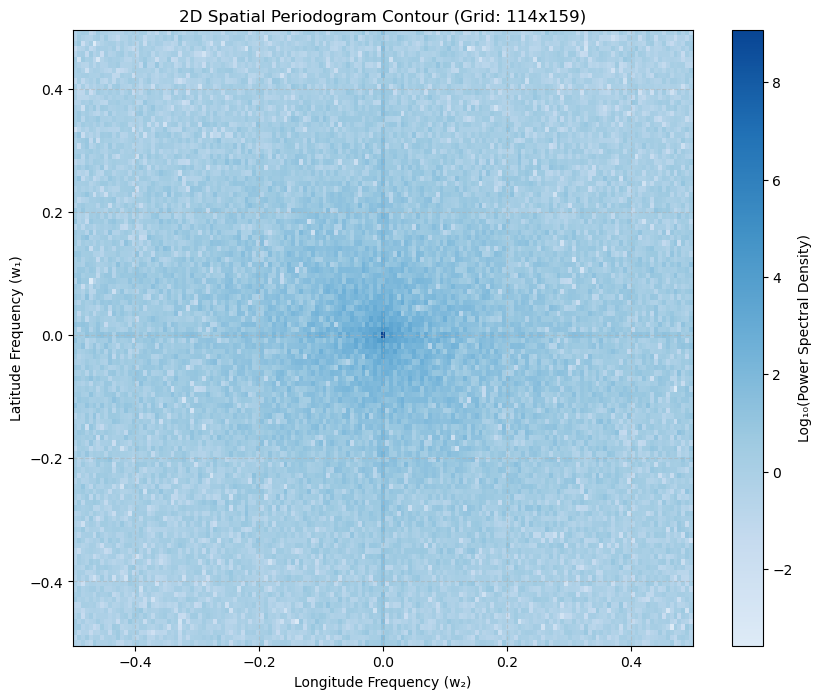

In [15]:
def plot_2d_periodogram_contour_ori(data_2d: np.ndarray):
    """
    Computes the 2D Periodogram (Power Spectral Density) of the input data
    and plots it using contour lines in the frequency domain.

    The plot axes represent the normalized spatial frequencies (wavenumbers),
    with the DC component (zero frequency) centered at (0, 0).

    Args:
        data_2d (np.ndarray): A 2D array of ozone values (assumed to be 64x128).
    """
    M, N = data_2d.shape
    N_TOTAL = M * N
    


    # --- 1. Compute 2D FFT and PSD ---
    
    # Compute the 2D Discrete Fourier Transform (DFT)
    fft_coeff = fftn(data_2d)
    
    # Calculate the Power Spectral Density (Periodogram): |FFT|^2 / N
    psd_2d = np.abs(fft_coeff)**2 / N_TOTAL

    # Shift the zero frequency (DC component) to the center of the array
    psd_shifted = fftshift(psd_2d)

    # --- 2. Generate Frequency Axes ---
    
    # fftfreq generates normalized frequencies, ranging from -0.5 to 0.5 cycles/sample
    # We use fftshift to put the zero frequency in the center, matching the PSD shift.
    
    # Frequencies for the Latitude dimension (M=64)
    freq_lat = fftshift(fftfreq(M))
    
    # Frequencies for the Longitude dimension (N=128)
    freq_lon = fftshift(fftfreq(N))

    # Create 2D meshgrid for plotting (Lon Freq, Lat Freq)
    # Note: meshgrid orders X (columns/Lon) first, then Y (rows/Lat)
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon, freq_lat)

    # --- 3. Plotting (Contour) ---

    # Define custom blue colors
    blue_colors = [
        (222/255, 235/255, 247/255), # Lightest blue/white -> Low Power
        (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255),
        (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255),
        (33/255, 113/255, 181/255),
        (8/255, 69/255, 148/255)    # Darkest blue -> High Power (Strong Spectrum)
    ]
    # Create the custom colormap using the LinearSegmentedColormap class
    blue_cmap = LinearSegmentedColormap.from_list("custom_blue", blue_colors)
    
    plt.figure(figsize=(10, 8))
    
    # Use log scale for the contour levels since PSD usually spans many orders of magnitude
    log_psd = np.log10(psd_shifted + np.finfo(float).eps) # Add epsilon to avoid log(0)
    
    # Create 15 logarithmically spaced contour levels
    levels = np.linspace(log_psd.min(), log_psd.max(), 15)
    
    # Use pcolormesh for continuous color mapping of the PSD (using the custom blue map)
    plt.pcolormesh(freq_grid_lon, freq_grid_lat, log_psd, shading='auto', cmap=blue_cmap)
    
    # Overlay contour lines for clarity
    # Note: The white contour lines were removed to enhance color intuition
    
    plt.colorbar(label='Log₁₀(Power Spectral Density)')
    
    # Set labels based on the standard convention (Long Freq on X, Lat Freq on Y)
    plt.xlabel('Longitude Frequency (w₂)')
    plt.ylabel('Latitude Frequency (w₁)')
    plt.title(f'2D Spatial Periodogram Contour (Grid: {M}x{N})')
    
    # Ensure axes are square or equal if desired (optional)
    # plt.gca().set_aspect('equal')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

day = 2
keyhour = 4
keys = list(daily_hourly_maps_dw[day].keys())
df1 = daily_hourly_maps_dw[day][keys[keyhour]]

n_lat = len(df1[:,0].unique())
n_lon = len(df1[:,1].unique())
ozone_signal_2d = df1[:, 2].numpy().reshape(n_lat, n_lon)

plot_2d_periodogram_contour_ori(ozone_signal_2d)

average version

Averaging Periodogram for hour index 3 across 4 days...
  - Detected Grid Dimensions: 114 x 159
  - Successfully processed Day 0.
  - Successfully processed Day 1.
  - Successfully processed Day 2.
  - Successfully processed Day 3.


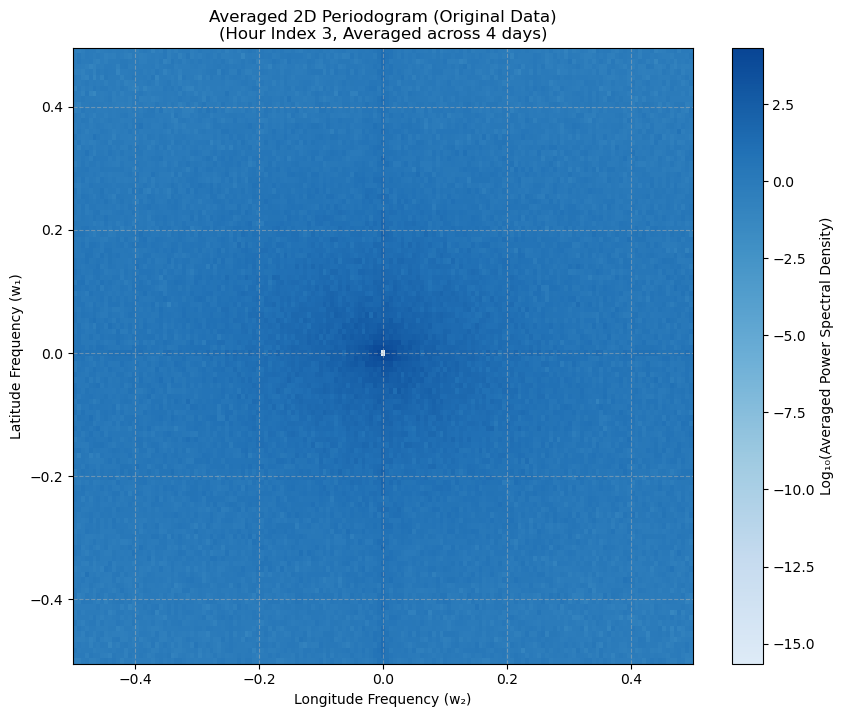

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.fft import fftn, fftshift, fftfreq
from matplotlib.colors import LinearSegmentedColormap

# --- 1. Helper: Compute Single PSD (Periodogram) ---
def calculate_periodogram(data_2d: np.ndarray):
    """
    Computes the 2D Power Spectral Density (Periodogram) for a single grid.
    PSD = |FFT|^2 / N_Total
    """
    M, N = data_2d.shape
    N_TOTAL = M * N
    
    # Demean to center the signal
    d_demeaned = data_2d - np.mean(data_2d)
    
    # FFT
    fft_coeff = fftn(d_demeaned)
    
    # PSD calculation
    psd_2d = np.abs(fft_coeff)**2 / N_TOTAL
    
    return fftshift(psd_2d)

# --- 2. Helper: Plotting ---
def plot_averaged_periodogram_contour(avg_psd: np.ndarray, M: int, N: int, num_snapshots: int):
    """
    Plots the final Averaged Periodogram.
    """
    freq_lat = fftshift(fftfreq(M))
    freq_lon = fftshift(fftfreq(N))
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon, freq_lat)

    # Custom Blue Colormap
    blue_cmap = LinearSegmentedColormap.from_list("custom_blue", [
        (222/255, 235/255, 247/255), (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255), (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255), (33/255, 113/255, 181/255),
        (8/255, 69/255, 148/255)
    ])
    
    plt.figure(figsize=(10, 8))
    
    # Log scale for visibility
    log_psd = np.log10(avg_psd + np.finfo(float).eps) 
    
    plt.pcolormesh(freq_grid_lon, freq_grid_lat, log_psd, shading='auto', cmap=blue_cmap)
    plt.colorbar(label='Log₁₀(Averaged Power Spectral Density)')
    
    plt.xlabel('Longitude Frequency (w₂)')
    plt.ylabel('Latitude Frequency (w₁)')
    
    # Title reflects what data was averaged
    plt.title(f'Averaged 2D Periodogram (Original Data)\n(Hour Index {keyhour}, Averaged across {num_snapshots} days)')
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

## --- Main Script Logic ---

# Define which days and hour to process (Using your Logic)
days_to_average = np.arange(4) # Use the first four days: [0, 1, 2, 3]
keyhour = 3                    # Targeting the 4th available hour in the day
psd_list = []
M, N = -1, -1                  # Placeholder for grid dimensions

print(f"Averaging Periodogram for hour index {keyhour} across {len(days_to_average)} days...")

for day in days_to_average:
    try:
        # User's Logic: Access dictionary keys as a list
        keys = list(daily_hourly_maps_dw[day].keys())
        
        # Load data for the target hour (df1)
        df1 = daily_hourly_maps_dw[day][keys[keyhour]]
        
        # Grid dimensions detection (Run only once on the first valid day)
        if M == -1: 
            n_lat = len(np.unique(df1[:,0]))
            n_lon = len(np.unique(df1[:,1]))
            M, N = n_lat, n_lon
            print(f"  - Detected Grid Dimensions: {M} x {N}")
            
        # Reshape: Ensure strictly M x N
        # (Assuming data is ordered or fits the shape naturally as per your logic)
        if torch.is_tensor(df1):
            ozone_signal = df1[:, 2].numpy().reshape(M, N)
        else:
            ozone_signal = df1[:, 2].reshape(M, N)

        # Calculate Periodogram (PSD) for this day's hour
        daily_psd = calculate_periodogram(ozone_signal)
        psd_list.append(daily_psd)
        
        print(f"  - Successfully processed Day {day}.")

    except KeyError:
        print(f"  - Skipped Day {day}: Key not found in dictionary.")
    except Exception as e:
        print(f"  - Could not process Day {day}. Reason: {e}")

# --- Averaging and Plotting ---
if psd_list:
    # Stack and Average
    avg_psd = np.mean(np.array(psd_list), axis=0)
    
    # Plot
    plot_averaged_periodogram_contour(avg_psd, M, N, len(psd_list))
else:
    print("\nNo data was successfully processed. Cannot generate plot.")

Averaging cross-periodogram for hour 3 and 4 across 4 days...
  - Successfully processed Day 0.
  - Successfully processed Day 1.
  - Successfully processed Day 2.
  - Successfully processed Day 3.


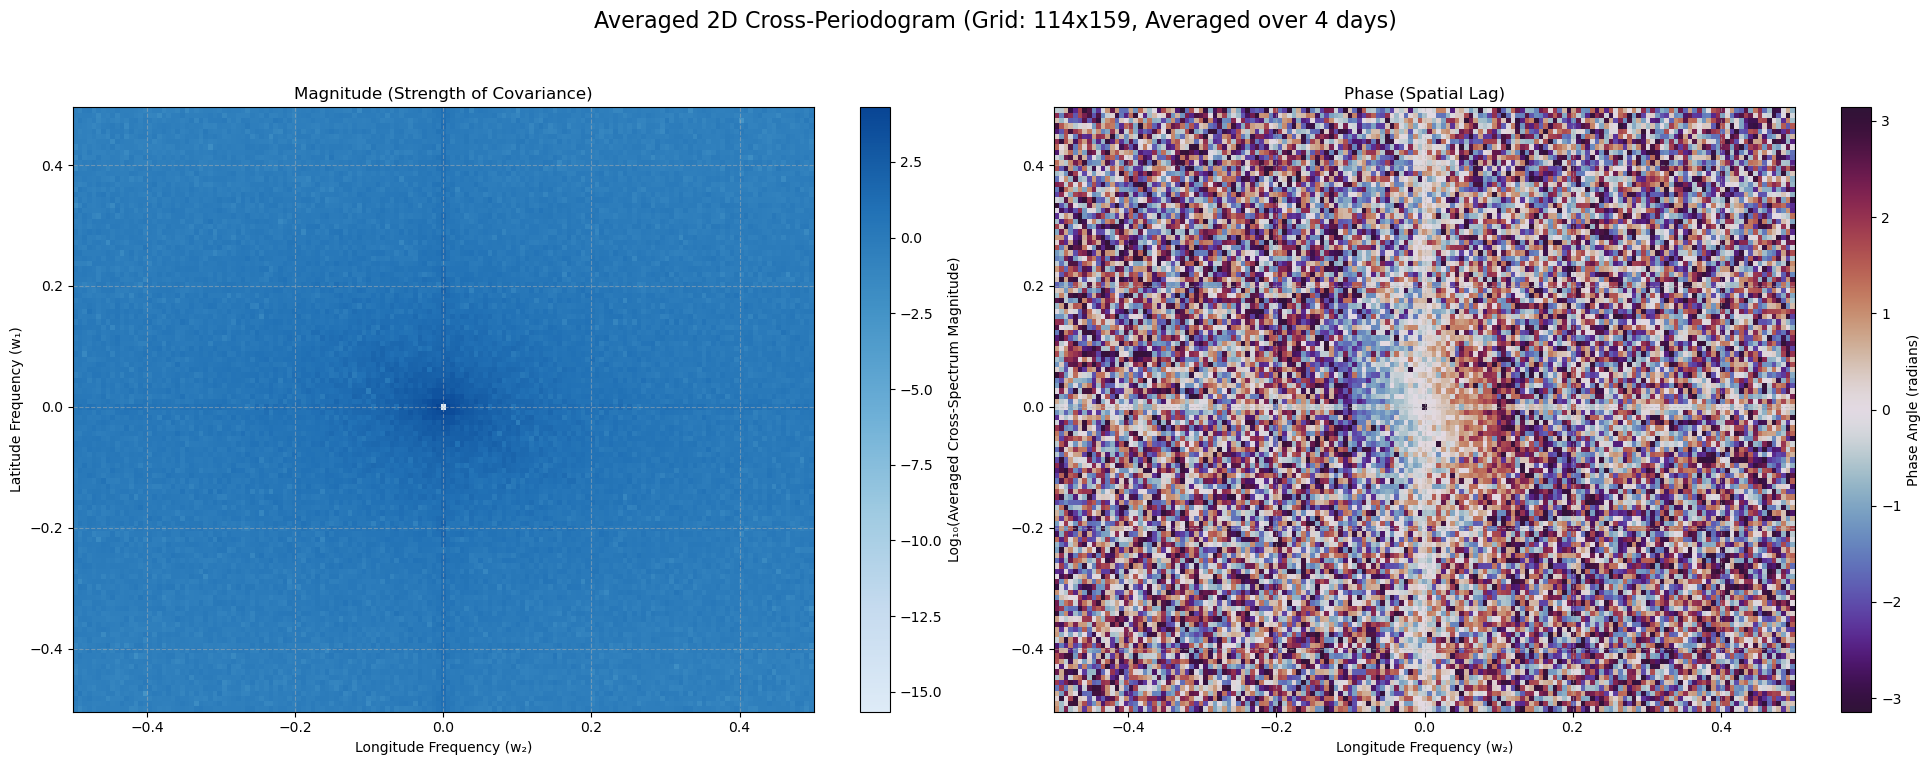

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, fftshift, fftfreq
from matplotlib.colors import LinearSegmentedColormap

def calculate_cross_spectrum(data1_2d: np.ndarray, data2_2d: np.ndarray):
    """
    Helper function to compute the 2D cross-spectrum for a single pair of datasets.
    Returns the complex-valued, shifted cross-spectrum.
    """
    if data1_2d.shape != data2_2d.shape:
        raise ValueError("Input data arrays must have the same dimensions.")
    
    M, N = data1_2d.shape
    N_TOTAL = M * N

    # Demean, FFT, and compute the cross-spectrum
    d1_demeaned = data1_2d - np.mean(data1_2d)
    d2_demeaned = data2_2d - np.mean(data2_2d)
    fft1 = fftn(d1_demeaned)
    fft2 = fftn(d2_demeaned)
    cross_spectrum = (fft1 * np.conj(fft2)) / N_TOTAL
    
    return fftshift(cross_spectrum)

def plot_averaged_cross_periodogram(avg_cross_spec: np.ndarray, M: int, N: int, num_days: int):
    """
    Plots the magnitude and phase of a pre-averaged 2D cross-periodogram.
    """
    # --- 1. Separate Averaged Magnitude and Phase ---
    magnitude = np.abs(avg_cross_spec)
    phase = np.angle(avg_cross_spec)

    # --- 2. Generate Frequency Axes ---
    freq_lat = fftshift(fftfreq(M))
    freq_lon = fftshift(fftfreq(N))
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon, freq_lat)

    # --- 3. Plotting (Two Subplots) ---
    blue_cmap = LinearSegmentedColormap.from_list("custom_blue", [
        (222/255, 235/255, 247/255), (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255), (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255), (33/255, 113/255, 181/255),
        (8/255, 69/255, 148/255)
    ])

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    title = f'Averaged 2D Cross-Periodogram (Grid: {M}x{N}, Averaged over {num_days} days)'
    fig.suptitle(title, fontsize=16)

    # -- Plot 1: Magnitude --
    ax = axes[0]
    log_magnitude = np.log10(magnitude + np.finfo(float).eps)
    im1 = ax.pcolormesh(freq_grid_lon, freq_grid_lat, log_magnitude, cmap=blue_cmap, shading='auto')
    fig.colorbar(im1, ax=ax, label='Log₁₀(Averaged Cross-Spectrum Magnitude)')
    ax.set_title('Magnitude (Strength of Covariance)')
    ax.set_xlabel('Longitude Frequency (w₂)')
    ax.set_ylabel('Latitude Frequency (w₁)')
    ax.grid(True, linestyle='--', alpha=0.5)

    # -- Plot 2: Phase --
    ax = axes[1]
    im2 = ax.pcolormesh(freq_grid_lon, freq_grid_lat, phase, cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi, shading='auto')
    fig.colorbar(im2, ax=ax, label='Phase Angle (radians)')
    ax.set_title('Phase (Spatial Lag)')
    ax.set_xlabel('Longitude Frequency (w₂)')
    ax.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## --- Main Script Logic ---
# This part loops through the days, calculates, and averages the results.

# Define which days and hour to process
days_to_average = np.arange(4) # Use the first four days
keyhour = 3
cross_spectra_list = []
M, N = -1, -1 # Placeholder for grid dimensions

print(f"Averaging cross-periodogram for hour {keyhour} and {keyhour+1} across {len(days_to_average)} days...")

for day in days_to_average:
    try:
        keys = list(daily_hourly_maps_dw[day].keys())
        
        # Load data for the first hour
        df1 = daily_hourly_maps_dw[day][keys[keyhour]]
        if M == -1: # Get grid dimensions on the first successful load
            n_lat = len(np.unique(df1[:,0]))
            n_lon = len(np.unique(df1[:,1]))
            M, N = n_lat, n_lon
        ozone_signal_1 = df1[:, 2].numpy().reshape(M, N)

        # Load data for the consecutive hour
        df2 = daily_hourly_maps_dw[day][keys[keyhour + 1]]
        ozone_signal_2 = df2[:, 2].numpy().reshape(M, N)
        
        # Calculate the cross-spectrum for this day and add it to our list
        daily_cross_spec = calculate_cross_spectrum(ozone_signal_1, ozone_signal_2)
        cross_spectra_list.append(daily_cross_spec)
        print(f"  - Successfully processed Day {day}.")

    except Exception as e:
        print(f"  - Could not process Day {day}. Reason: {e}")

# --- Averaging and Plotting ---
if cross_spectra_list:
    # Stack all the daily spectra into a 3D array and average along the 'day' axis
    avg_cross_spec = np.mean(np.array(cross_spectra_list), axis=0)
    
    # Plot the final averaged result
    plot_averaged_cross_periodogram(avg_cross_spec, M, N, len(cross_spectra_list))
else:
    print("\nNo data was successfully processed. Cannot generate plot.")